In [1]:
import sys
import os
import glob

import numpy as np
import pandas as pd

import librosa
import librosa.display

import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import multilabel_confusion_matrix, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

import math

import torch
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Upload data and extract Mel-spectrograms

In [2]:
from google.colab import drive
drive.mount('/content/drive')

main_dir = "/content/drive/MyDrive/LCT course/ABI-1 Corpus/accents"

Mounted at /content/drive


## Extract Mel-spectrograms

In [3]:
# Returns a list of Mel-spectrograms for each 3-second chunk of the audio
# If the last segment is shorter than 3 seconds, it is ignored
def get_mel_spectrogram(wavfile_path, chunk_seconds=None):
    sig, fs = librosa.load(wavfile_path, sr=16000)

    # Normalize between [-1,1]
    sig /= np.max(np.abs(sig), axis=0)

    if not chunk_seconds:
        chunk_samples = len(sig)
    else:
        # Get samples per segment
        chunk_samples = fs * chunk_seconds

    melspecs = []

    for i in range(0, math.floor(len(sig) / chunk_samples)):
        melspec = librosa.feature.melspectrogram(y=sig[chunk_samples*i: chunk_samples*(i+1)],
                                                sr=fs,
                                                center=True,
                                                n_fft=1024,
                                                hop_length=512,
                                                n_mels=128)
        melspec = librosa.power_to_db(melspec, ref=1.0)

        # Normalize to [0,1]
        scaler = MinMaxScaler(feature_range=(0, 1), copy=False, clip=True)
        scaler.fit_transform(melspec)

        melspecs.append(melspec)

    return melspecs

In [4]:
df = pd.DataFrame([], columns=["Speaker", "Spectrogram"])

wav_count = 0

for (dirname, dirs, files) in os.walk(main_dir):
    for file in files:
        if file.endswith(".wav"):
            source_file = os.path.join(dirname, file)
            source_file_split = source_file.split("/")
            speaker = source_file_split[-2]

            wav_count += 1
            if wav_count % 50 == 0:
                print(wav_count, "files analysed")

            # Extract Mel spectrograms and append to dataframe with speaker info
            melspecs = get_mel_spectrogram(wavfile_path=source_file, chunk_seconds=3)
            for melspec in melspecs:
                list_row = [speaker, melspec]
                df.loc[len(df)] = list_row

print(df.shape)

50 files analysed
100 files analysed
150 files analysed
200 files analysed
250 files analysed
300 files analysed
350 files analysed
400 files analysed
450 files analysed
500 files analysed
550 files analysed
600 files analysed
650 files analysed
700 files analysed
750 files analysed
800 files analysed
850 files analysed
(13300, 2)


## Transform speakers' labels into numerical data

In [5]:
speakers = list(df["Speaker"].unique())
speaker_dict = dict(enumerate(speakers))

df["Speaker_label"] = df.apply(lambda x: [k for k, v in speaker_dict.items() if v == x["Speaker"]][0], axis=1)
df.drop(["Speaker"], axis=1, inplace=True)

## Plot number of extracted spectrograms per speaker

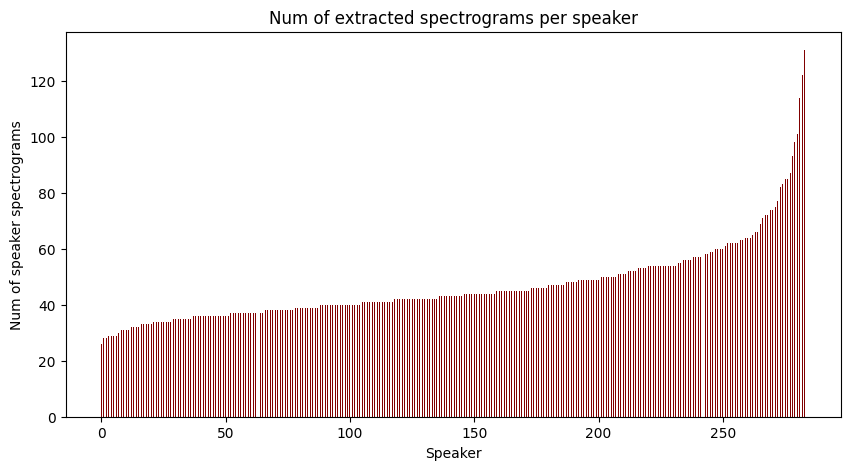

In [6]:
nums_of_spectrograms = []

speaker_labels = list(df["Speaker_label"].unique())
for speaker_label in speaker_labels:
    num_of_spectrograms = len(df[df["Speaker_label"] == speaker_label])
    nums_of_spectrograms.append(num_of_spectrograms)

nums_of_spectrograms.sort()

# Create the barplot
fig = plt.figure(figsize = (10, 5))

plt.bar(np.arange(0, len(speaker_labels), 1), nums_of_spectrograms,
        color ='maroon', width = 0.4)

plt.xlabel("Speaker")
plt.ylabel("Num of speaker spectrograms")
plt.title("Num of extracted spectrograms per speaker")
plt.show()

# Separate the data and convert it to tensors

## Separate into train, validation and test (with segments per speaker separated in the same proportion)

In [9]:
unique_speakers = list(df["Speaker_label"].unique())

X_train = pd.DataFrame(columns=["Spectrogram"])
y_train = pd.DataFrame(columns=["Speaker_label"])

X_val = pd.DataFrame(columns=["Spectrogram"])
y_val = pd.DataFrame(columns=["Speaker_label"])

X_test = pd.DataFrame(columns=["Spectrogram"])
y_test = pd.DataFrame(columns=["Speaker_label"])

for speaker in unique_speakers:
    df_speaker = df[df["Speaker_label"] == speaker]
    num_of_samples = df_speaker.shape[0]

    df_speaker = df_speaker.sample(frac=1).reset_index(drop=True)
    train_speaker = df_speaker.loc[0: math.floor(num_of_samples * 0.6)]
    val_speaker = df_speaker.loc[int(num_of_samples * 0.6): int(num_of_samples * 0.8)]
    test_speaker = df_speaker.loc[int(num_of_samples * 0.8): num_of_samples-1]

    X_train = pd.concat([X_train, train_speaker[["Spectrogram"]].copy()], ignore_index=True, sort=False)
    X_val = pd.concat([X_val, val_speaker[["Spectrogram"]].copy()], ignore_index=True, sort=False)
    X_test = pd.concat([X_test, test_speaker[["Spectrogram"]].copy()], ignore_index=True, sort=False)

    y_train = pd.concat([y_train, train_speaker[["Speaker_label"]].copy()], ignore_index=True, sort=False)
    y_val = pd.concat([y_val, val_speaker[["Speaker_label"]].copy()], ignore_index=True, sort=False)
    y_test = pd.concat([y_test, test_speaker[["Speaker_label"]].copy()], ignore_index=True, sort=False)

## Convert data into tensors

In [10]:
# Get numpy arrays from dataframes and stack them into one array
data_to_convert = [X_train, X_val, X_test]
converted_data = []

for data in data_to_convert:
    nparrays = []
    for i in range(data.shape[0]):
        nparrays.append(data.iloc[i, 0][None, :, :])
    stacked_array = np.vstack(nparrays).astype("float32")
    converted_data.append(stacked_array)

X_train_np = converted_data[0]
X_train_np = X_train_np.reshape((X_train_np.shape[0], 1, X_train_np.shape[1], X_train_np.shape[2]))
X_val_np = converted_data[1]
X_val_np = X_val_np.reshape((X_val_np.shape[0], 1, X_val_np.shape[1], X_val_np.shape[2]))
X_test_np = converted_data[2]
X_test_np = X_test_np.reshape((X_test_np.shape[0], 1, X_test_np.shape[1], X_test_np.shape[2]))

y_train_np = y_train.to_numpy().astype('float32')
y_val_np = y_val.to_numpy().astype('float32')
y_test_np = y_test.to_numpy().astype('float32')

# Convert numpy arrays to tensors
X_train_tensor = torch.tensor(X_train_np).float()
X_val_tensor = torch.tensor(X_val_np).float()
X_test_tensor = torch.tensor(X_test_np).float()

y_train_tensor = torch.tensor(y_train_np)
y_val_tensor = torch.tensor(y_val_np)
y_test_tensor = torch.tensor(y_test_np)

# Experiments with different models

## Shallow model

### Shallow model - Training

<ipython-input-11-787e87d1916c>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_x = torch.tensor(X_train_tensor[batch_row_indexes], device=device)
<ipython-input-11-787e87d1916c>:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_y = torch.tensor(y_train_tensor[batch_row_indexes], device=device)
<ipython-input-11-787e87d1916c>:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_batch_x = torch.tensor(X_val_tensor[batch_val_row_indexes], device=device)
<ipython-input-11-787e87d1916c>:85: UserWarning: To copy construct from a

Epoch: 5      Train loss: 4.3295083 Val accuracy: 0.10547163

Epoch: 10      Train loss: 1.9414904 Val accuracy: 0.29841217

Epoch: 15      Train loss: 0.6879139 Val accuracy: 0.4351338

Epoch: 20      Train loss: 0.29498693 Val accuracy: 0.4786984

Epoch: 25      Train loss: 0.16785847 Val accuracy: 0.5011745

Epoch: 30      Train loss: 0.1069376 Val accuracy: 0.5094418

Epoch: 35      Train loss: 0.075783245 Val accuracy: 0.5331902

Epoch: 40      Train loss: 0.060200814 Val accuracy: 0.53468704

Epoch: 45      Train loss: 0.04679763 Val accuracy: 0.5438352

Epoch: 50      Train loss: 0.038112596 Val accuracy: 0.55747974

Epoch: 55      Train loss: 0.031779207 Val accuracy: 0.55770427

Epoch: 60      Train loss: 0.027510244 Val accuracy: 0.55518264

Epoch: 65      Train loss: 0.02451741 Val accuracy: 0.5643538

Epoch: 70      Train loss: 0.021688769 Val accuracy: 0.57236785

Epoch: 75      Train loss: 0.019355757 Val accuracy: 0.5729608

Epoch: 80      Train loss: 0.018364979 Val acc

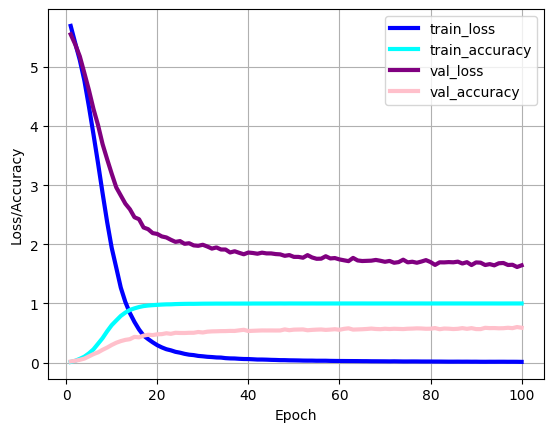

In [11]:
class ShallowModel(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.ConvLayer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, 3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.MaxPool2d(3)
        )
        self.ConvLayer2 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, 3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),
            torch.nn.MaxPool2d(3)
        )
        self.Lin1 = torch.nn.Sequential(
            torch.nn.Linear(14976, 2048),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5)
        )
        self.Lin2 = torch.nn.Sequential(
            torch.nn.Linear(2048, 284)
        )

    def forward(self, x):
        x = self.ConvLayer1(x)
        x = self.ConvLayer2(x)
        x = x.view(x.size(0), -1)
        x = self.Lin1(x)
        return self.Lin2(x)


shallow_model = ShallowModel()
shallow_model.to(device)
optimiser = torch.optim.SGD(shallow_model.parameters(), lr=0.0001, weight_decay=0.000001, momentum=0.95)
criterion = torch.nn.CrossEntropyLoss()
batch_size = 64
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []


for epoch in range(1, 100+1):
    epoch_train_loss, epoch_train_accuracy = 0, 0
    steps = 0

    row_indexes = np.arange(len(X_train_tensor))
    np.random.shuffle(row_indexes)

    for i in range(0, len(X_train_tensor), batch_size):
        steps += 1
        # Prepare batches for training
        batch_row_indexes = row_indexes[i:i+batch_size]
        batch_x = torch.tensor(X_train_tensor[batch_row_indexes], device=device)
        batch_y = torch.tensor(y_train_tensor[batch_row_indexes], device=device)
        # Get predictions
        optimiser.zero_grad()
        predicted = shallow_model(batch_x)
        targets = batch_y[:, 0].type(torch.LongTensor).to(device)

        # Calculate training loss and accuracy
        loss = criterion(predicted, targets)
        epoch_train_loss += loss
        loss.backward()
        optimiser.step()
        train_accuracy = (torch.argmax(predicted, 1) == batch_y[:, 0]).float().mean()
        epoch_train_accuracy += train_accuracy

    avg_train_loss = epoch_train_loss / steps
    train_losses.append(avg_train_loss.detach().cpu().tolist())
    avg_train_accuracy = epoch_train_accuracy / steps
    train_accuracies.append(avg_train_accuracy.detach().cpu().tolist())

    # Calculate validation loss and accuracy
    val_batch_size = 64
    val_steps = 0
    val_loss, val_accuracy = 0, 0
    val_row_indexes = np.arange(len(X_val_tensor))
    np.random.shuffle(val_row_indexes)

    with torch.no_grad():
        for i in range(0, len(X_val_tensor), val_batch_size):
            val_steps += 1
            batch_val_row_indexes = val_row_indexes[i:i+val_batch_size]
            val_batch_x = torch.tensor(X_val_tensor[batch_val_row_indexes], device=device)
            val_batch_y = torch.tensor(y_val_tensor[batch_val_row_indexes], device=device)

            val_predicted = shallow_model(val_batch_x)
            val_targets = val_batch_y[:, 0].type(torch.LongTensor).to(device)
            val_loss += criterion(val_predicted, val_targets)
            val_accuracy += (torch.argmax(val_predicted, 1) == val_batch_y[:, 0]).float().mean()

        val_loss = val_loss / val_steps
        val_losses.append(val_loss.detach().cpu().tolist())
        val_accuracy = val_accuracy / val_steps
        val_accuracies.append(val_accuracy.detach().cpu().tolist())

    if epoch % 5 == 0:
        print("Epoch:", epoch, "     Train loss:", avg_train_loss.detach().cpu().numpy(), "Val accuracy:", val_accuracy.detach().cpu().numpy())
        print()

# Plot training and validation loss and accuracy
(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss/Accuracy')
ax.plot(range(1, 101), train_losses, color='blue', label="train_loss", linestyle='-', linewidth=3)
ax.plot(range(1, 101), train_accuracies, color='cyan', label="train_accuracy", linestyle='-', linewidth=3)
ax.plot(range(1, 101), val_losses, color='purple', label="val_loss", linestyle='-', linewidth=3)
ax.plot(range(1, 101), val_accuracies, color='pink', label="val_accuracy", linestyle='-', linewidth=3)
ax.legend()
ax.grid()
fig.savefig('Shallow_loss_accuracy.png',dpi=400)

### Shallow model - accuracy on the test set and  confusion matrix

<ipython-input-12-516ab388f45d>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_batch_x = torch.tensor(X_test_tensor[batch_test_row_indexes], device=device)
<ipython-input-12-516ab388f45d>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_batch_y = torch.tensor(y_test_tensor[batch_test_row_indexes], device=device)



Accuracy on the test set:  0.5443314 

F1-score on the test set:  0.5102652985254287 



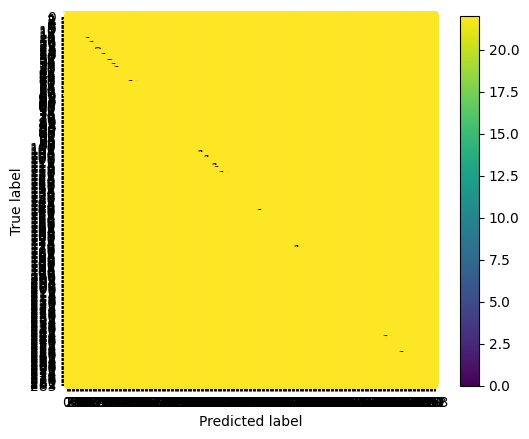

In [12]:
test_batch_size = 64
test_row_indexes = np.arange(len(X_test_tensor))
np.random.shuffle(test_row_indexes)

test_predicted = []
targets = []

with torch.no_grad():
    for i in range(0, len(X_test_tensor) - test_batch_size, test_batch_size):
        batch_test_row_indexes = test_row_indexes[i:i+test_batch_size]
        test_batch_x = torch.tensor(X_test_tensor[batch_test_row_indexes], device=device)
        test_batch_y = torch.tensor(y_test_tensor[batch_test_row_indexes], device=device)

        batch_test_predicted = shallow_model(test_batch_x)
        test_predicted.append(batch_test_predicted)
        targets.append(test_batch_y)

    test_predicted = torch.vstack((test_predicted))
    target = torch.vstack((targets))

    accuracy = (torch.argmax(test_predicted.detach().cpu(), 1) == target.detach().cpu()[:, 0]).float().mean()
    print()
    print("Accuracy on the test set: ", accuracy.detach().cpu().numpy(), "\n")

    f1 = f1_score(target.detach().cpu()[:, 0], torch.argmax(test_predicted.detach().cpu(), 1).float(), average="macro")
    print("F1-score on the test set: ", f1, "\n")

    cm = confusion_matrix(torch.argmax(test_predicted, 1).detach().cpu().numpy(), target[:, 0].detach().cpu().numpy())
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    disp.figure_.savefig("Shallow_cm.png")

### Compare true positives with the number of spectrograms per speaker

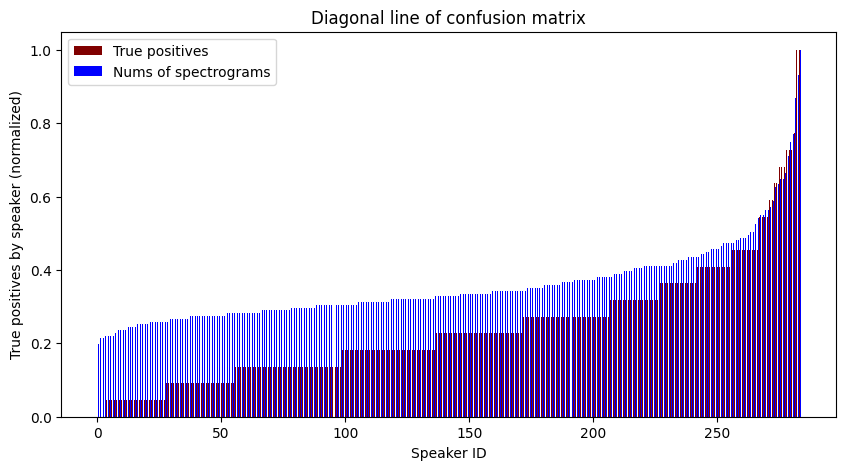

In [13]:
# Get all elements of the main diagonal line (true positives)
tp = []
for i in range(cm.shape[0]):
    tp.append(cm[i][i])
tp.sort()

# Normalize values to compare the curves
tp = [elem / max(tp) for elem in tp]
nums_of_spectrograms = [elem / max(nums_of_spectrograms) for elem in nums_of_spectrograms]

fig = plt.figure(figsize = (10, 5))

plt.bar(np.arange(0, cm.shape[0], 1), tp, color ='maroon',
        width = 0.4, label="True positives")
plt.bar(np.arange(0.5, cm.shape[0] + 0.5, 1), nums_of_spectrograms, color='blue', width=0.4, label="Nums of spectrograms")

plt.xlabel("Speaker ID")
plt.ylabel("True positives by speaker (normalized)")
plt.title("Diagonal line of confusion matrix")
plt.legend()
plt.savefig('Shallow_tp_speakers.png',dpi=400)
plt.show()

## VGG

### VGG - Training

<ipython-input-14-1eec543af3dc>:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_x = torch.tensor(X_train_tensor[batch_row_indexes], device=device)
<ipython-input-14-1eec543af3dc>:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_y = torch.tensor(y_train_tensor[batch_row_indexes], device=device)
<ipython-input-14-1eec543af3dc>:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_batch_x = torch.tensor(X_val_tensor[batch_val_row_indexes], device=device)
<ipython-input-14-1eec543af3dc>:107: UserWarning: To copy construct from

Epoch: 5      Train loss: 5.287005 Val accuracy: 0.024144463

Epoch: 10      Train loss: 3.8670099 Val accuracy: 0.14386156

Epoch: 15      Train loss: 1.9773293 Val accuracy: 0.41738743

Epoch: 20      Train loss: 0.9303081 Val accuracy: 0.6294876

Epoch: 25      Train loss: 0.47477165 Val accuracy: 0.7221688

Epoch: 30      Train loss: 0.27358276 Val accuracy: 0.7671936

Epoch: 35      Train loss: 0.17483139 Val accuracy: 0.7875464

Epoch: 40      Train loss: 0.110057384 Val accuracy: 0.8012852

Epoch: 45      Train loss: 0.084384225 Val accuracy: 0.80233186

Epoch: 50      Train loss: 0.05852393 Val accuracy: 0.8172637

Epoch: 55      Train loss: 0.048635367 Val accuracy: 0.8273711

Epoch: 60      Train loss: 0.036126368 Val accuracy: 0.8226157

Epoch: 65      Train loss: 0.033549763 Val accuracy: 0.82848674

Epoch: 70      Train loss: 0.026572771 Val accuracy: 0.8281333

Epoch: 75      Train loss: 0.023968542 Val accuracy: 0.8318973

Epoch: 80      Train loss: 0.018706696 Val accur

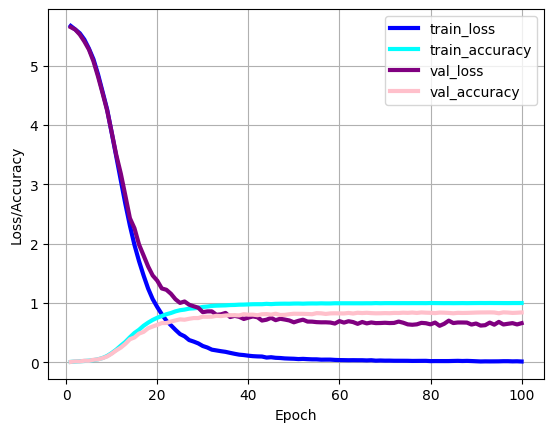

In [14]:
class VGGModel(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.ConvLayer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, 3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(32, 32, 3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
        )
        self.pool1 = torch.nn.MaxPool2d(2)
        self.ConvLayer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, 3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.Conv2d(64, 64, 3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64)
        )
        self.pool2 = torch.nn.MaxPool2d(2)
        self.ConvLayer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, 3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),
            torch.nn.Conv2d(128, 128, 3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),
            torch.nn.Conv2d(128, 128, 3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128)
        )
        self.pool3 = torch.nn.MaxPool2d(2)
        self.Lin1 = torch.nn.Sequential(
            torch.nn.Linear(9856, 1024),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(1024, 1024),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5)
        )
        self.Lin2 = torch.nn.Linear(1024, 284)

    def forward(self, x):
        x = self.pool1(self.ConvLayer1(x))
        x = self.pool2(self.ConvLayer2(x))
        x = self.pool3(self.ConvLayer3(x))
        x = x.view(x.size(0), -1)
        x = self.Lin1(x)
        return self.Lin2(x)

vgg_model = VGGModel()
vgg_model.to(device)

optimiser = torch.optim.SGD(vgg_model.parameters(), lr=0.0005, weight_decay=0.000001, momentum=0.97)

criterion = torch.nn.CrossEntropyLoss()

batch_size = 128
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []


for epoch in range(1, 100+1):
    epoch_train_loss, epoch_train_accuracy = 0, 0
    steps = 0

    row_indexes = np.arange(len(X_train_tensor))
    np.random.shuffle(row_indexes)

    for i in range(0, len(X_train_tensor), batch_size):
        steps += 1
        # Prepare batches for training
        batch_row_indexes = row_indexes[i:i+batch_size]
        batch_x = torch.tensor(X_train_tensor[batch_row_indexes], device=device)
        batch_y = torch.tensor(y_train_tensor[batch_row_indexes], device=device)
        # Get predictions
        optimiser.zero_grad()
        predicted = vgg_model(batch_x)
        targets = batch_y[:, 0].type(torch.LongTensor).to(device)

        # Calculate training loss and accuracy
        loss = criterion(predicted, targets)
        epoch_train_loss += loss
        loss.backward()
        optimiser.step()
        train_accuracy = (torch.argmax(predicted, 1) == batch_y[:, 0]).float().mean()
        epoch_train_accuracy += train_accuracy

    avg_train_loss = epoch_train_loss / steps
    train_losses.append(avg_train_loss.detach().cpu().tolist())
    avg_train_accuracy = epoch_train_accuracy / steps
    train_accuracies.append(avg_train_accuracy.detach().cpu().tolist())

    # Calculate validation loss and accuracy
    val_batch_size = 128
    val_steps = 0
    val_loss, val_accuracy = 0, 0
    val_row_indexes = np.arange(len(X_val_tensor))
    np.random.shuffle(val_row_indexes)

    with torch.no_grad():
        for i in range(0, len(X_val_tensor), val_batch_size):
            val_steps += 1
            batch_val_row_indexes = val_row_indexes[i:i+val_batch_size]
            val_batch_x = torch.tensor(X_val_tensor[batch_val_row_indexes], device=device)
            val_batch_y = torch.tensor(y_val_tensor[batch_val_row_indexes], device=device)

            val_predicted = vgg_model(val_batch_x)
            val_targets = val_batch_y[:, 0].type(torch.LongTensor).to(device)
            val_loss += criterion(val_predicted, val_targets)
            val_accuracy += (torch.argmax(val_predicted, 1) == val_batch_y[:, 0]).float().mean()

        val_loss = val_loss / val_steps
        val_losses.append(val_loss.detach().cpu().tolist())
        val_accuracy = val_accuracy / val_steps
        val_accuracies.append(val_accuracy.detach().cpu().tolist())

    if epoch % 5 == 0:
        print("Epoch:", epoch, "     Train loss:", avg_train_loss.detach().cpu().numpy(), "Val accuracy:", val_accuracy.detach().cpu().numpy())
        print()

(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss/Accuracy')
ax.plot(range(1, 101), train_losses, color='blue', label="train_loss", linestyle='-', linewidth=3)
ax.plot(range(1, 101), train_accuracies, color='cyan', label="train_accuracy", linestyle='-', linewidth=3)
ax.plot(range(1, 101), val_losses, color='purple', label="val_loss", linestyle='-', linewidth=3)
ax.plot(range(1, 101), val_accuracies, color='pink', label="val_accuracy", linestyle='-', linewidth=3)
ax.legend()
ax.grid()
plt.savefig('VGG_loss_accuracy.png',dpi=400)

### VGG - accuracy on the test set and  confusion matrix

<ipython-input-15-dc3344e493bd>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_batch_x = torch.tensor(X_test_tensor[batch_test_row_indexes], device=device)
<ipython-input-15-dc3344e493bd>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_batch_y = torch.tensor(y_test_tensor[batch_test_row_indexes], device=device)



Accuracy on the test set:  0.81831396 

F1-score on the test set:  0.8139034360160634 



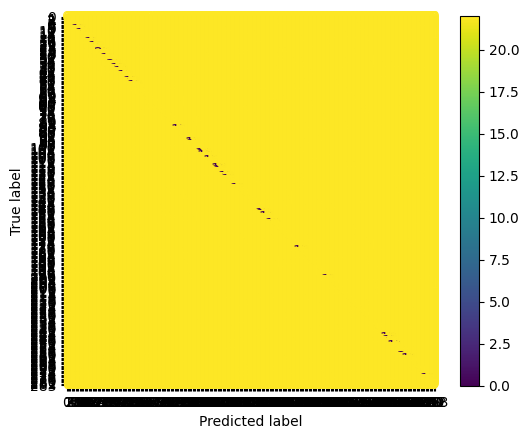

In [15]:
test_batch_size = 32
test_row_indexes = np.arange(len(X_test_tensor))
np.random.shuffle(test_row_indexes)

test_predicted = []
targets = []

with torch.no_grad():
    for i in range(0, len(X_test_tensor) - test_batch_size, test_batch_size):
        batch_test_row_indexes = test_row_indexes[i:i+test_batch_size]
        test_batch_x = torch.tensor(X_test_tensor[batch_test_row_indexes], device=device)
        test_batch_y = torch.tensor(y_test_tensor[batch_test_row_indexes], device=device)

        batch_test_predicted = vgg_model(test_batch_x)
        test_predicted.append(batch_test_predicted)
        targets.append(test_batch_y)

    test_predicted = torch.vstack((test_predicted))
    target = torch.vstack((targets))

    accuracy = (torch.argmax(test_predicted.detach().cpu(), 1) == target.detach().cpu()[:, 0]).float().mean()
    print()
    print("Accuracy on the test set: ", accuracy.detach().cpu().numpy(), "\n")

    f1 = f1_score(target.detach().cpu()[:, 0], torch.argmax(test_predicted.detach().cpu(), 1).float(), average="macro")
    print("F1-score on the test set: ", f1, "\n")

    cm = confusion_matrix(torch.argmax(test_predicted, 1).detach().cpu().numpy(), target[:, 0].detach().cpu().numpy())
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    disp.figure_.savefig("VGG_cm.png")

### Compare true positives with the number of spectrograms per speaker

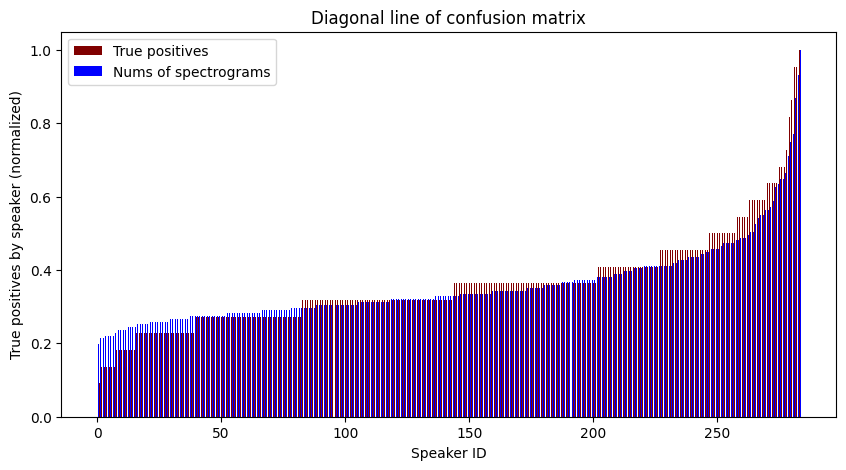

In [16]:
# Get all elements of the main diagonal line (true positives)
tp = []
for i in range(cm.shape[0]):
    tp.append(cm[i][i])
tp.sort()

# Normalize values to compare the curves
tp = [elem / max(tp) for elem in tp]
nums_of_spectrograms = [elem / max(nums_of_spectrograms) for elem in nums_of_spectrograms]

fig = plt.figure(figsize = (10, 5))

plt.bar(np.arange(0, cm.shape[0], 1), tp, color ='maroon',
        width = 0.4, label="True positives")
plt.bar(np.arange(0.5, cm.shape[0] + 0.5, 1), nums_of_spectrograms, color='blue', width=0.4, label="Nums of spectrograms")

plt.xlabel("Speaker ID")
plt.ylabel("True positives by speaker (normalized)")
plt.title("Diagonal line of confusion matrix")
plt.legend()
plt.savefig('VGG_tp_speakers.png',dpi=400)
plt.show()

## VGG with LSTM blocks

### VGG with LSTM blocks - Training

epoch loss


<ipython-input-17-4a6b40986295>:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_x = torch.tensor(X_train_tensor[batch_row_indexes], device=device)
<ipython-input-17-4a6b40986295>:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_y = torch.tensor(y_train_tensor[batch_row_indexes], device=device)
<ipython-input-17-4a6b40986295>:117: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_batch_x = torch.tensor(X_val_tensor[batch_val_row_indexes], device=device)
<ipython-input-17-4a6b40986295>:118: UserWarning: To copy construct from

Epoch: 5      Train loss: 5.2278857
Val accuracy: 0.020082185

Epoch: 10      Train loss: 3.4606466
Val accuracy: 0.15103614

Epoch: 15      Train loss: 1.7752044
Val accuracy: 0.41256297

Epoch: 20      Train loss: 0.7753341
Val accuracy: 0.59580463

Epoch: 25      Train loss: 0.38431653
Val accuracy: 0.6394348

Epoch: 30      Train loss: 0.28094587
Val accuracy: 0.6694586

Epoch: 35      Train loss: 0.16319603
Val accuracy: 0.6981707

Epoch: 40      Train loss: 0.11620564
Val accuracy: 0.70296764

Epoch: 45      Train loss: 0.084010005
Val accuracy: 0.723036

Epoch: 50      Train loss: 0.06628246
Val accuracy: 0.72808963

Epoch: 55      Train loss: 0.06548831
Val accuracy: 0.74364567

Epoch: 60      Train loss: 0.05548539
Val accuracy: 0.724831

Epoch: 65      Train loss: 0.03714771
Val accuracy: 0.7393265

Epoch: 70      Train loss: 0.036678776
Val accuracy: 0.73155546

Epoch: 75      Train loss: 0.038858186
Val accuracy: 0.7267862

Epoch: 80      Train loss: 0.02453193
Val accuracy

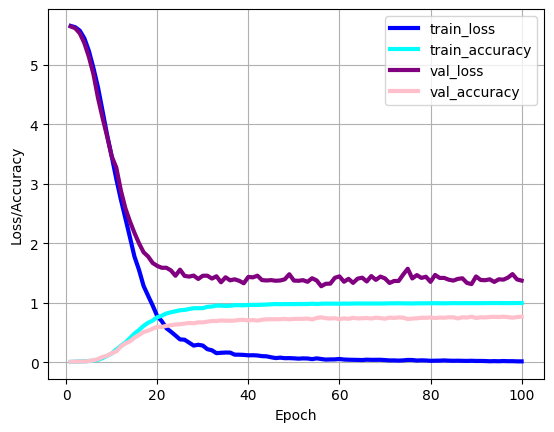

In [17]:
class VGGAndLSTMModel(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.ConvLayer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, 3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(32, 32, 3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
        )
        self.pool1 = torch.nn.MaxPool2d(2)
        self.ConvLayer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, 3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.Conv2d(64, 64, 3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64)
        )
        self.pool2 = torch.nn.MaxPool2d(2)
        self.ConvLayer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, 3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),
            torch.nn.Conv2d(128, 128, 3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),
            torch.nn.Conv2d(128, 128, 3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128)
        )
        self.pool3 = torch.nn.MaxPool2d(2)

        self.flatten = torch.nn.Flatten()
        self.lstm = torch.nn.LSTM(input_size=9856, hidden_size=512, num_layers=1, batch_first=True)

        self.Lin1 = torch.nn.Sequential(
            torch.nn.Linear(512, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(512, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5)
        )
        self.Lin2 = torch.nn.Linear(512, 284)

    def forward(self, x):
        x = self.pool1(self.ConvLayer1(x))
        x = self.pool2(self.ConvLayer2(x))
        x = self.pool3(self.ConvLayer3(x))

        x = self.flatten(x)
        x = x.unsqueeze(1)

        # LSTM-type recurrent blocks
        x, _ = self.lstm(x[:, -1, :])

        x = self.Lin1(x)
        return self.Lin2(x)

vgg_lstm_model = VGGAndLSTMModel()
vgg_lstm_model.to(device)

optimiser = torch.optim.SGD(vgg_lstm_model.parameters(), lr=0.01, weight_decay=0.000001, momentum=0.97)

criterion = torch.nn.CrossEntropyLoss()

batch_size = 128
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

print("epoch", "loss")

for epoch in range(1, 100+1):
    epoch_train_loss, epoch_train_accuracy = 0, 0
    steps = 0

    row_indexes = np.arange(len(X_train_tensor))
    np.random.shuffle(row_indexes)

    for i in range(0, len(X_train_tensor), batch_size):
        steps += 1
        # Prepare batches for training
        batch_row_indexes = row_indexes[i:i+batch_size]
        batch_x = torch.tensor(X_train_tensor[batch_row_indexes], device=device)
        batch_y = torch.tensor(y_train_tensor[batch_row_indexes], device=device)
        # Get predictions
        optimiser.zero_grad()
        predicted = vgg_lstm_model(batch_x)
        targets = batch_y[:, 0].type(torch.LongTensor).to(device)

        # Calculate training loss and accuracy
        loss = criterion(predicted, targets)
        epoch_train_loss += loss
        loss.backward()
        optimiser.step()
        train_accuracy = (torch.argmax(predicted, 1) == batch_y[:, 0]).float().mean()
        epoch_train_accuracy += train_accuracy

    avg_train_loss = epoch_train_loss / steps
    train_losses.append(avg_train_loss.detach().cpu().tolist())
    avg_train_accuracy = epoch_train_accuracy / steps
    train_accuracies.append(avg_train_accuracy.detach().cpu().tolist())

    # Calculate validation loss and accuracy
    val_batch_size = 128
    val_steps = 0
    val_loss, val_accuracy = 0, 0
    val_row_indexes = np.arange(len(X_val_tensor))
    np.random.shuffle(val_row_indexes)

    with torch.no_grad():
        for i in range(0, len(X_val_tensor), val_batch_size):
            val_steps += 1
            batch_val_row_indexes = val_row_indexes[i:i+val_batch_size]
            val_batch_x = torch.tensor(X_val_tensor[batch_val_row_indexes], device=device)
            val_batch_y = torch.tensor(y_val_tensor[batch_val_row_indexes], device=device)

            val_predicted = vgg_lstm_model(val_batch_x)
            val_targets = val_batch_y[:, 0].type(torch.LongTensor).to(device)
            val_loss += criterion(val_predicted, val_targets)
            val_accuracy += (torch.argmax(val_predicted, 1) == val_batch_y[:, 0]).float().mean()

        val_loss = val_loss / val_steps
        val_losses.append(val_loss.detach().cpu().tolist())
        val_accuracy = val_accuracy / val_steps
        val_accuracies.append(val_accuracy.detach().cpu().tolist())

    if epoch % 5 == 0:
        print("Epoch:", epoch, "     Train loss:", avg_train_loss.detach().cpu().numpy())
        print("Val accuracy:", val_accuracy.detach().cpu().numpy())
        print()

(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss/Accuracy')
ax.plot(range(1, 101), train_losses, color='blue', label="train_loss", linestyle='-', linewidth=3)
ax.plot(range(1, 101), train_accuracies, color='cyan', label="train_accuracy", linestyle='-', linewidth=3)
ax.plot(range(1, 101), val_losses, color='purple', label="val_loss", linestyle='-', linewidth=3)
ax.plot(range(1, 101), val_accuracies, color='pink', label="val_accuracy", linestyle='-', linewidth=3)
ax.legend()
ax.grid()
plt.savefig('VGG_LSTM_loss_accuracy.png',dpi=400)

### VGG with LSTM blocks - accuracy on the test set and confusion matrix

<ipython-input-18-daa9144dc9c1>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_batch_x = torch.tensor(X_test_tensor[batch_test_row_indexes], device=device)
<ipython-input-18-daa9144dc9c1>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_batch_y = torch.tensor(y_test_tensor[batch_test_row_indexes], device=device)



Accuracy on the test set:  0.7176599 

F1-score on the test set:  0.7081191306889697 



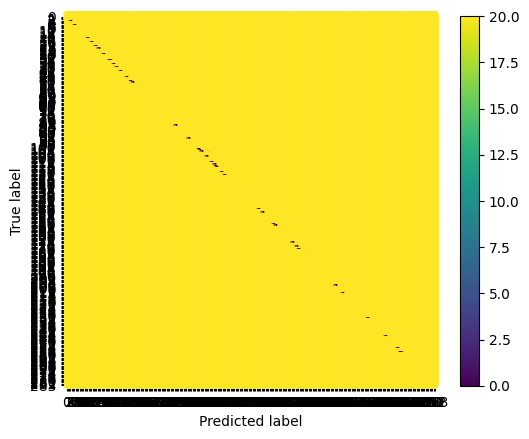

In [18]:
test_batch_size = 32
test_row_indexes = np.arange(len(X_test_tensor))
np.random.shuffle(test_row_indexes)

test_predicted = []
targets = []

with torch.no_grad():
    for i in range(0, len(X_test_tensor) - test_batch_size, test_batch_size):
        batch_test_row_indexes = test_row_indexes[i:i+test_batch_size]
        test_batch_x = torch.tensor(X_test_tensor[batch_test_row_indexes], device=device)
        test_batch_y = torch.tensor(y_test_tensor[batch_test_row_indexes], device=device)

        batch_test_predicted = vgg_lstm_model(test_batch_x)
        test_predicted.append(batch_test_predicted)
        targets.append(test_batch_y)

    test_predicted = torch.vstack((test_predicted))
    target = torch.vstack((targets))

    accuracy = (torch.argmax(test_predicted.detach().cpu(), 1) == target.detach().cpu()[:, 0]).float().mean()
    print()
    print("Accuracy on the test set: ", accuracy.detach().cpu().numpy(), "\n")

    f1 = f1_score(target.detach().cpu()[:, 0], torch.argmax(test_predicted.detach().cpu(), 1).float(), average="macro")
    print("F1-score on the test set: ", f1, "\n")

    cm = confusion_matrix(torch.argmax(test_predicted, 1).detach().cpu().numpy(), target[:, 0].detach().cpu().numpy())
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    disp.figure_.savefig("VGG_LSTM_cm.png")

### Compare true positives with the number of spectrograms per speaker

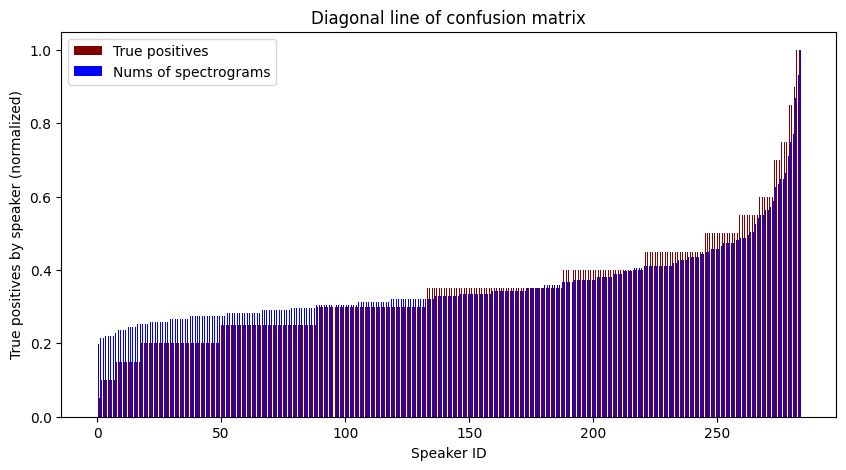

In [19]:
# Get all elements of the main diagonal line (true positives)
tp = []
for i in range(cm.shape[0]):
    tp.append(cm[i][i])
tp.sort()

# Normalize values to compare the curves
tp = [elem / max(tp) for elem in tp]
nums_of_spectrograms = [elem / max(nums_of_spectrograms) for elem in nums_of_spectrograms]

fig = plt.figure(figsize = (10, 5))

plt.bar(np.arange(0, cm.shape[0], 1), tp, color ='maroon',
        width = 0.4, label="True positives")
plt.bar(np.arange(0.5, cm.shape[0] + 0.5, 1), nums_of_spectrograms, color='blue', width=0.4, label="Nums of spectrograms")

plt.xlabel("Speaker ID")
plt.ylabel("True positives by speaker (normalized)")
plt.title("Diagonal line of confusion matrix")
plt.legend()
plt.savefig('VGG_LSTM_tp_speakers.png',dpi=400)
plt.show()